# Lab 2: Comparing Word Embeddings Across Domains

In this lab, we'll explore how word2vec learns semantic relationships in different domains by comparing embeddings trained on two very different corpora:
1. Song lyrics from the Spotify Million Song Dataset
2. Biomedical paper abstracts from PubMed

An important note: The biomedical corpus was trained on substantially more data than the lyrics corpus. This means that some of the differences we observe may be due to data volume rather than domain-specific patterns. However, this itself provides an interesting angle for analysis - how does data volume affect the capture of different types of semantic relationships?

## Learning Objectives
- Understand how domain and training data affect learned word relationships
- Compare semantic patterns across different domains
- Analyze differences between input and output embeddings
- Develop systematic approaches for embedding analysis

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import multiprocessing
from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('punkt')  # Download tokenizer data
# nltk.download('averaged_perceptron_tagger')
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple


pd.options.display.max_columns=None

In [2]:
abstracts_model = Word2Vec.load('https://www.dropbox.com/scl/fi/fktop15arvcy4nitkakmm/word2vec_abstractso.model?rlkey=20nonez9il815khk0j9yz4cqz&st=x8rh5h2k&dl=1')
songs_model = Word2Vec.load('https://www.dropbox.com/scl/fi/t5ac16sbccqu682rdqmez/song_lyrics.model?rlkey=5ry4v06f9e3jdkhma9efc8f9r&st=8gfldsoz&dl=1')

In [3]:
# Print basic model info
print("Biomedical Model:")
print(f"Vocabulary size: {len(abstracts_model.wv.key_to_index)}")
print(f"Vector size: {abstracts_model.vector_size}")

print("\nSong Lyrics Model:")
print(f"Vocabulary size: {len(songs_model.wv.key_to_index)}")
print(f"Vector size: {songs_model.vector_size}")

Biomedical Model:
Vocabulary size: 51380
Vector size: 100

Song Lyrics Model:
Vocabulary size: 12529
Vector size: 100


# Part 1: Word Similarity Analysis
To compare how words are represented across our two domains (biomedical papers and song lyrics), we'll conduct an analysis of their similarity patterns:
- First, we identify the common vocabulary - words that appear in both domains. This gives us a foundation for making fair comparisons. While each domain has its own specialized vocabulary, we're interested in how they represent the same words differently.
- From this shared vocabulary of approximately 6,000 words, we randomly sample 500 words (for expediency) to analyze in detail. For each of these 500 words (let's call one of them word x), we'll examine how it relates to all other shared words in each domain.
- In the biomedical domain, we calculate how similar word x is to every other shared word, creating what we call x_bm - a vector of similarity scores. We repeat this in the song lyrics domain to get x_sl. These similarity vectors capture how each domain "understands" word x in relation to other words.
- The key comparison comes from calculating the rank correlation between x_bm and x_sl. A high correlation suggests that word x maintains similar relationships with other words across both domains - in other words, both domains understand and use the word in similar ways. A low correlation indicates that the word's relationships with other words differ substantially between domains, suggesting domain-specific usage patterns.
- For example, the word "heart" might have a low correlation because it's used primarily in a medical sense in biomedical texts but metaphorically in lyrics. In contrast, common function words like "the" or "and" might show higher correlations because their usage patterns remain more consistent across domains. 

In [4]:
def compare_similarities(word: str, 
                       models: Dict[str, Word2Vec],
                       topn: int = 5) -> Dict[str, List[Tuple[str, float]]]:
    """
    Compare most similar words across different models
    
    Args:
        word: Target word to analyze
        models: Dictionary of domain models
        topn: Number of similar words to return
    
    Returns:
        Dictionary of similar words for each domain
    """
    results = {}
    for domain, model in models.items():
        if word in model.wv:
            results[domain] = model.wv.most_similar(word, topn=topn)
        else:
            results[domain] = []
    return results

def calculate_rank_correlation(word: str, 
                             model1: Word2Vec, 
                             model2: Word2Vec,
                             common_words: List[str]) -> float:
    """
    Calculate rank correlation of similarities between two models
    
    Args:
        word: Target word
        model1, model2: Models to compare
        common_words: List of words to compare similarities for
    
    Returns:
        Spearman rank correlation coefficient
    """
    if word not in model1.wv or word not in model2.wv:
        return None
        
    # Get similarities to common words in both models
    sims1 = [model1.wv.similarity(word, w) for w in common_words if w in model1.wv]
    sims2 = [model2.wv.similarity(word, w) for w in common_words if w in model2.wv]
    
    if len(sims1) > 1 and len(sims2) > 1:
        return spearmanr(sims1, sims2)[0]
    return None

# Create dictionary of models
models = {
    'biomedical': abstracts_model,
    'lyrics': songs_model
}


In [5]:
# First get common words between models
common_words = list(set(abstracts_model.wv.key_to_index) & 
                   set(songs_model.wv.key_to_index))
print(f"Number of words in both domains: {len(common_words)}")
print(f"Share of words in abstracts that are in songs: {len(common_words) / len(abstracts_model.wv.key_to_index):.3f}")
print(f"Share of words in songs that are in abstracts: {len(common_words) / len(songs_model.wv.key_to_index):.3f}")


Number of words in both domains: 6810
Share of words in abstracts that are in songs: 0.133
Share of words in songs that are in abstracts: 0.544


In [6]:
sample_of_common_words = pd.DataFrame(common_words, columns=['word']).sample(1000)


In [7]:
center = {}
for i, cw in enumerate(sample_of_common_words.values):
    if i % 250 == 0:
        print(i, sample_of_common_words.shape[0])
    sim_words = compare_similarities(cw[0], models, 7000)
    df_bio = pd.DataFrame(sim_words['biomedical'], columns=['word', 'sim'])
    df_song = pd.DataFrame(sim_words['lyrics'], columns=['word', 'sim'])
    df = df_bio.merge(df_song, on=['word'], suffixes=['_bio', '_song'])
    center[cw[0]] = df.iloc[:, 1:].corr(method='spearman').iloc[0, 1]
    

0 1000
250 1000
500 1000
750 1000


In [8]:
rank_corrs = pd.DataFrame.from_dict(center, orient='index').reset_index()
rank_corrs.columns=['word', 'corr']
rank_corrs.sort_values(by='corr', inplace=True)

In [9]:
# 20 least correlated
rank_corrs.head(20)

# 20 most correlated
rank_corrs.tail(20)


,word,corr
816,log,-0.127695
101,nana,-0.120253
441,borderline,-0.116026
536,tab,-0.105100
15,graves,-0.095859
219,gene,-0.094439
946,fatty,-0.087927
31,pals,-0.085620
153,castle,-0.085083
135,dr,-0.084789


,word,corr
104,peas,0.348282
141,colorado,0.350430
805,ce,0.351378
34,brazil,0.351591
397,de,0.354621
174,spice,0.355144
939,oregon,0.363338
458,baltimore,0.364152
680,cherries,0.367447
879,biscuits,0.377801


<AxesSubplot: xlabel='corr', ylabel='Count'>

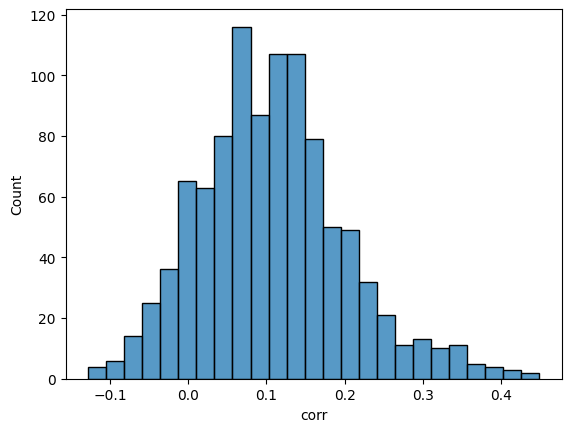

In [10]:
# The distrubtion of rank correlations
sns.histplot(rank_corrs, x='corr')

### Excercises:
Consider the following hypothesis: Geographic terms show high cross-domain correlation because they participate in similar semantic relationships across domains, even when the specific contexts of their usage differ. This is because geographic relationships (like country-capital pairs, regional groupings, or spatial relationships) are fundamental and consistent, unlike more context-dependent relationships like those between emotions or technical terms. 

 1. Take some of the geography related words that had high correlations and look at which words are closest to them in the two domains (biomedical and song lyrics). Is the relationship between the source word and the neighbors words similar in the two domains? 

2) Take some emotion-related or technicial/scientific-related terms and investigate the nearest words across the two domains. Do these neighboring words support the hypothesis above? What is the difference in the contexts that appear in the two lists?



# Part 2: Understanding Input and Output Vector Spaces

Now we'll dive deeper into an interesting aspect of the word2vec architecture: the distinction between input and output vectors.

When word2vec trains, it actually learns two different vector representations for each word:
- The first representation is the input vector, which we get from what's called the input embedding matrix. When we feed a target word like "pizza" into the model, we use its input vector to try to predict the surrounding context words. Think of this input vector as capturing how useful a word is for predicting what words might appear around it. It represents the word's role as a clue or predictor.
- The second representation is the output vector, stored in what's called the output embedding matrix. These vectors represent words in their role as predictions or answers. When our model sees "pizza" and tries to predict "delicious," it compares the input vector for "pizza" with the output vector for "delicious." The more closely these vectors align, the more confident the model is in predicting that relationship.
- These two representations emerge from the model's training objective. When we say "dog" appears in the context of "bark", the model uses the input vector for "dog" to help predict "bark". But when "dog" is the word being predicted, the model uses its output vector. In theory, these vectors could capture different aspects of meaning - the input vector might represent how a word helps predict other words, while the output vector represents how that word is predicted by its context.

This raises some interesting questions:
- How similar are a word's input and output vectors? 
- Do some types of words have more consistent representations across these spaces than others?
- Does this consistency relate to properties like:
 - Word frequency (do common words have more consistent representations?)
 - Part of speech (do nouns behave differently than verbs?)
 - Word length (do longer, potentially more complex words show different patterns?)
- Do these patterns differ between our biomedical and lyrics domains?


Understanding these patterns can give us insight into how word2vec learns to represent meaning and whether words play different roles when providing context versus being predicted. Let's start exploring this by calculating the cosine similarity between each word's input and output vectors.

Analyzing input-output similarities...


<Figure size 1200x600 with 0 Axes>

<AxesSubplot: >

<AxesSubplot: xlabel='similarity', ylabel='Density'>

Text(0.5, 1.0, 'Distribution of Input-Output Similarities')

Text(0.5, 0, 'Cosine Similarity')

<AxesSubplot: >

<AxesSubplot: xlabel='domain', ylabel='similarity'>

Text(0.5, 1.0, 'Input-Output Similarities by Domain')

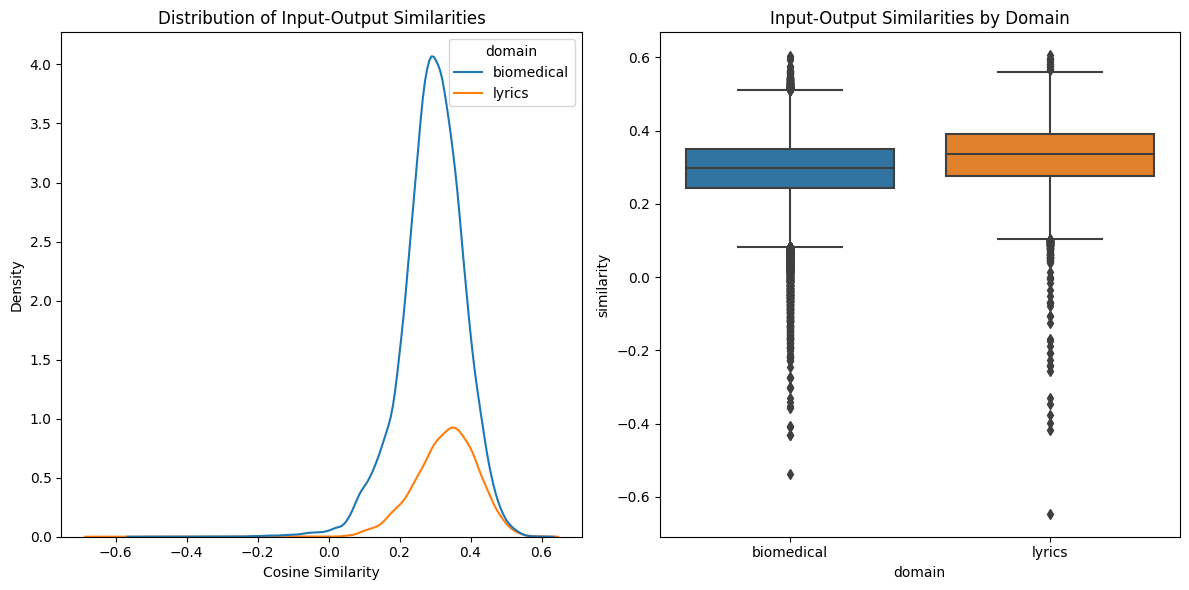

In [11]:
def analyze_input_output_similarity(model: Word2Vec):
    """
    Analyze the cosine similarity between input and output vectors for each word.
    
    This function examines how similarly words are represented in the input space
    (when they serve as context) versus the output space (when they are being predicted).
    A high similarity suggests the word has consistent representation across both spaces.
    
    Returns:
        DataFrame containing word-level similarity scores and vector statistics
    """
    similarities = []
    
    for word in model.wv.index_to_key:
        # Get input and output vectors
        input_vec = model.wv[word]
        output_vec = model.syn1neg[model.wv.key_to_index[word]]
        
        # Normalize vectors
        input_norm = np.linalg.norm(input_vec)
        output_norm = np.linalg.norm(output_vec)
        input_vec_norm = input_vec / input_norm
        output_vec_norm = output_vec / output_norm
        
        # Calculate cosine similarity
        similarity = np.dot(input_vec_norm, output_vec_norm)
        
        similarities.append({
            'word': word,
            'similarity': similarity,
            'input_norm': input_norm,
            'output_norm': output_norm
        })
    
    return pd.DataFrame(similarities)

# Analyze both models
print("Analyzing input-output similarities...")
bio_similarities = analyze_input_output_similarity(abstracts_model)
lyrics_similarities = analyze_input_output_similarity(songs_model)

# Add domain labels
bio_similarities['domain'] = 'biomedical'
lyrics_similarities['domain'] = 'lyrics'

# Combine results
all_similarities = pd.concat([bio_similarities, lyrics_similarities])

# Create visualizations to compare distributions
plt.figure(figsize=(12, 6))

# Distribution plot
plt.subplot(1, 2, 1)
sns.kdeplot(data=all_similarities, x='similarity', hue='domain')
plt.title('Distribution of Input-Output Similarities')
plt.xlabel('Cosine Similarity')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=all_similarities, x='domain', y='similarity')
plt.title('Input-Output Similarities by Domain')

plt.tight_layout()

In [12]:
# Function to analyze extreme cases
def analyze_extreme_cases(df: pd.DataFrame, n: int = 10) -> dict:
    """
    Analyze words with highest and lowest input-output similarities.
    
    This helps us understand which words have consistent representations
    across spaces versus those that are represented differently.
    """
    results = {}
    
    # Get extreme cases for each domain
    for domain in df['domain'].unique():
        domain_df = df[df['domain'] == domain]
        
        most_similar = domain_df.nlargest(n, 'similarity')[['word', 'similarity']]
        least_similar = domain_df.nsmallest(n, 'similarity')[['word', 'similarity']]
        
        results[domain] = {
            'most_similar': most_similar,
            'least_similar': least_similar
        }
    
    return results

# Analyze extreme cases
extreme_cases = analyze_extreme_cases(all_similarities)

# Print findings
for domain, cases in extreme_cases.items():
    print(f"\n{domain.upper()} DOMAIN")
    print("=" * 50)
    
    print("\nMost similar input-output representations:")
    print(cases['most_similar'].to_string(index=False))
    
    print("\nLeast similar input-output representations:")
    print(cases['least_similar'].to_string(index=False))


BIOMEDICAL DOMAIN

Most similar input-output representations:
         word  similarity
    composite    0.603318
        white    0.599204
       middle    0.593259
 longitudinal    0.576476
       living    0.572975
        heavy    0.565382
        fiber    0.563679
       bundle    0.563099
consolidation    0.561041
   attachment    0.558926

Least similar input-output representations:
        word  similarity
         and   -0.536199
          of   -0.430385
         the   -0.430200
     besides   -0.410197
          in   -0.407083
      whilst   -0.358159
    addition   -0.351917
additionally   -0.340453
         was   -0.329975
        with   -0.303203

LYRICS DOMAIN

Most similar input-output representations:
   word  similarity
   bang    0.606021
  fever    0.598021
     oo    0.595833
   funk    0.592830
   boom    0.588909
     la    0.583475
    bop    0.582034
america    0.575650
   rock    0.572892
    bow    0.569074

Least similar input-output representations:
word  s

In [13]:
# Calculate summary statistics
summary_stats = all_similarities.groupby('domain').agg({
    'similarity': ['mean', 'std', 'median', 'min', 'max']
}).round(3)

print("\nSummary Statistics:")
print(summary_stats)


Summary Statistics:
           similarity                            
                 mean    std median    min    max
domain                                           
biomedical      0.292  0.089  0.297 -0.536  0.603
lyrics          0.330  0.089  0.337 -0.646  0.606


#### Excercises
1. Write a function that returns the top n most similar words in the output embeddings space. (The `wv.most_similar` function that comes with gensim is for the input embeddings here.).




2. Using the function that you wrote, look at the most similar words for the most similar and least similar words (when comparing input- and output-embeddings). Do this for both domains. 
Do words with high input/output similarity also have the same closest words? What about for words with low input/output similarity? 

## Part 3: Testing Analogies Across Domains

Let's explore how well each model captures semantic relationships through analogy testing.

The classic example of word embeddings capturing analogies is "king:queen::man:woman" - the idea that the vector difference between "king" and "queen" is similar to the vector difference between "man" and "woman". This suggests the model has learned the concept of gender relationships and it is represented linearly. 

In this section, we'll test different types of analogies in each domain. We're particularly interested in:

1. Whether certain types of relationships are better captured in one domain vs the other
2. If there are differences between how input embeddings (word vectors) and output embeddings (context vectors) capture these relationships



In [14]:
from dataclasses import dataclass
from typing import List, Tuple, Optional, Literal

@dataclass
class Analogy:
    input_1: str
    input_2: str
    input_3: str
    expected: str
    explanation: str = ""

# Gender/Sex Relationships
gender_analogies = [
    Analogy("man", "woman", "king", "queen"),
    Analogy("father", "mother", "son", "daughter"),
    Analogy("brother", "sister", "uncle", "aunt"),
    Analogy("husband", "wife", "groom", "bride"),
    Analogy("actor", "actress", "waiter", "waitress"),
    Analogy("sir", "madam", "mr", "mrs")
]

# Geographic Relationships
geographic_analogies = [
    Analogy("france", "paris", "japan", "tokyo"),
    Analogy("china", "chinese", "spain", "spanish"),
    Analogy("russia", "moscow", "uk", "london"),
    Analogy("egypt", "cairo", "iran", "tehran"),
    Analogy("berlin", "germany", "dublin", "ireland"),
    Analogy("europe", "european", "asia", "asian")
]

# Currency Relationships
currency_analogies = [
    Analogy("japan", "yen", "uk", "pound"),
    Analogy("usa", "dollar", "europe", "euro"),
    Analogy("russia", "ruble", "china", "yuan"),
    Analogy("switzerland", "franc", "india", "rupee")
]

# Comparative/Superlative Relationships
comparative_analogies = [
    Analogy("good", "better", "bad", "worse"),
    Analogy("big", "biggest", "small", "smallest"),
    Analogy("hot", "hottest", "cold", "coldest"),
    Analogy("happy", "happiest", "sad", "saddest")
]

# Opposite Relationships
opposite_analogies = [
    Analogy("hot", "cold", "light", "dark"),
    Analogy("up", "down", "left", "right"),
    Analogy("rich", "poor", "strong", "weak"),
    Analogy("love", "hate", "friend", "enemy")
]

# Professional Relationships
professional_analogies = [
    Analogy("doctor", "hospital", "teacher", "school"),
    Analogy("chef", "restaurant", "pilot", "airplane"),
    Analogy("artist", "paint", "writer", "pen")
]

In [15]:
def test_analogy_with_embeddings(model, analogy: Analogy, 
                                embedding_type: Literal["input", "output", "both"] = "both", 
                                topn: int = 5) -> dict:
    """
    Test analogy using specified embedding type(s) and return results in a format
    suitable for DataFrame construction.
    
    Returns dictionary containing:
    - Basic analogy information
    - Top n predictions for each embedding type
    - Whether expected word was found
    - Rank of expected word if found
    - Similarity score of expected word if found
    """
    results = {
        'input_1': analogy.input_1,
        'input_2': analogy.input_2,
        'input_3': analogy.input_3,
        'expected': analogy.expected
    }
    
    try:
        # Test input embeddings
        if embedding_type in ["input", "both"]:
            input_vec = (model.wv[analogy.input_2] - 
                        model.wv[analogy.input_1] + 
                        model.wv[analogy.input_3])
            
            input_results = model.wv.similar_by_vector(input_vec, topn=topn + 3)
            
            # Filter out input words
            input_results = [(word, score) for word, score in input_results 
                           if word not in [analogy.input_1, analogy.input_2, analogy.input_3]][:topn]
            
            # Store top predictions
            results.update({'input_preds' : ', '.join(w for w, s in input_results)})
            
            # Check if expected word is in results
            expected_in_input = next(((i+1, score) for i, (word, score) in enumerate(input_results) 
                                    if word == analogy.expected), (None, None))
            results['input_expected_rank'] = expected_in_input[0]

        # Test output embeddings
        if embedding_type in ["output", "both"]:
            output_vec = (model.syn1neg[model.wv.key_to_index[analogy.input_2]] - 
                         model.syn1neg[model.wv.key_to_index[analogy.input_1]] + 
                         model.syn1neg[model.wv.key_to_index[analogy.input_3]])
            
            output_vec = output_vec / np.linalg.norm(output_vec)
            
            similarities = []
            for word in model.wv.index_to_key:
                if word not in [analogy.input_1, analogy.input_2, analogy.input_3]:
                    vec = model.syn1neg[model.wv.key_to_index[word]]
                    vec = vec / np.linalg.norm(vec)
                    sim = np.dot(output_vec, vec)
                    similarities.append((word, sim))
            
            output_results = sorted(similarities, key=lambda x: x[1], reverse=True)[:topn]
            
            # Store top predictions
            results.update({'output_preds' : ', '.join(w for w,s in output_results)})
            
            # Check if expected word is in results
            expected_in_output = next(((i+1, score) for i, (word, score) in enumerate(output_results) 
                                     if word == analogy.expected), (None, None))
            results['output_expected_rank'] = expected_in_output[0]

    except KeyError as e:
        results['error'] = str(e)
    
    return results

def analyze_analogies(model, analogy_sets: Dict[str, List[Analogy]], domain: str):
    """
    Test multiple sets of analogies and return results as a DataFrame
    """
    all_results = []
    
    for category, analogies in analogy_sets.items():
        for analogy in analogies:
            result = test_analogy_with_embeddings(model, analogy)
            result['category'] = category
            result['domain'] = domain
            all_results.append(result)
    
    # Create DataFrame
    df = pd.DataFrame(all_results)
    
    # Add success indicators
    df['input_success'] = df['input_expected_rank'].notna()
    df['output_success'] = df['output_expected_rank'].notna()
    df.drop(columns=['output_expected_rank', 'input_expected_rank'], inplace=True)
    
    df = df[df.input_preds.notna()]

    return df

In [16]:
# Test analogies and analyze results
analogy_sets = {
    'gender': gender_analogies,
    'geographic': geographic_analogies,
    'comparative': comparative_analogies,
    'opposite': opposite_analogies,
    'professional': professional_analogies
}

# Test in both domains
results_bio = analyze_analogies(abstracts_model, analogy_sets, 'biomedical')
results_lyrics = analyze_analogies(songs_model, analogy_sets, 'lyrics')

# Combine results
all_results = pd.concat([results_bio, results_lyrics])

In [17]:

all_results.head()


,input_1,input_2,input_3,expected,input_preds,output_preds,category,domain,error,input_success,output_success
0,man,woman,king,queen,"abdulaziz, abdullah, fahd, fahad, khalid","abdulaziz, university, riyadh, tertiary, princess",gender,biomedical,NaN,False,False
1,father,mother,son,daughter,"supraoptic, solitarius, tractus, kndy, mpoa","supraoptic, mayor, avons, sont, postrema",gender,biomedical,NaN,False,False
6,france,paris,japan,tokyo,"tokyo, sinai, osaka, fukuoka, essen","tokyo, essen, fukuoka, turin, kumamoto",geographic,biomedical,NaN,True,True
7,china,chinese,spain,spanish,"polish, greek, portuguese, spanish, italian","italian, polish, french, greek, portuguese",geographic,biomedical,NaN,True,False
8,russia,moscow,uk,london,"fukuoka, kingston, london, canadian, massachus...","rawalpindi, florence, leipzig, fukuoka, lausanne",geographic,biomedical,NaN,True,False


In [18]:
all_results.groupby(['category', 'domain'])[['input_success', 'output_success']].mean()
all_results.groupby(['category'])[['input_success', 'output_success']].mean()
all_results.groupby(['domain'])[['input_success', 'output_success']].mean()

input_success  output_success
category     domain                                   
comparative  biomedical       0.333333        0.333333
             lyrics           0.750000        0.500000
gender       biomedical       0.000000        0.000000
             lyrics           0.833333        0.666667
geographic   biomedical       0.833333        0.500000
             lyrics           0.333333        0.000000
opposite     biomedical       0.500000        0.250000
             lyrics           0.500000        0.500000
professional biomedical       0.000000        0.000000
             lyrics           0.333333        0.333333

,input_success,output_success
category,,
comparative,0.571429,0.428571
gender,0.625000,0.500000
geographic,0.666667,0.333333
opposite,0.500000,0.375000
professional,0.250000,0.250000


,input_success,output_success
domain,,
biomedical,0.5,0.3125
lyrics,0.6,0.4500


#### Exercise:


1, 
Design and test a new set of analogies that you would expect to work particularly well in:
 - The biomedical domain
 - The lyrics domain


## Part 4: Bias testing
Understanding bias in word embeddings is crucial because these models, trained on real-world text, can absorb and amplify societal biases present in their training data. The method we'll use here builds on a key insight: words that are conceptually related tend to be closer together in the embedding space. By examining how close different profession words are to gendered terms, we can measure potential gender biases in how these professions are represented.

Our approach follows a simplified version of the method introduced by Bolukbasi et al. in their influential paper "Man is to Computer Programmer as Woman is to Homemaker." We'll measure bias by comparing how similar each profession word is to a set of male-associated words (like "he," "man," "father") versus female-associated words (like "she," "woman," "mother"). If a profession is substantially closer to one gender's terms than the other's, this suggests the embedding has learned to associate that profession more strongly with that gender.

What makes this analysis particularly interesting in our context is that we can compare these biases across two very different domains - biomedical literature and song lyrics. This comparison might reveal whether gender biases manifest differently in technical academic writing versus popular culture.

In [19]:
def analyze_gender_bias(model, profession_words):
    """
    Analyze gender bias in profession words by measuring their 
    relative similarity to male/female reference words.
    
    This implementation follows the methodology from Bolukbasi et al.'s 
    "Man is to Computer Programmer as Woman is to Homemaker" paper, but simplified.
    """
    # Define sets of male and female reference words
    male_words = ['he', 'man', 'boy', 'male', 'father', 'son', 'brother']
    female_words = ['she', 'woman', 'girl', 'female', 'mother', 'daughter', 'sister']
    
    results = []
    for profession in profession_words:
        if profession not in model.wv:
            continue
            
        # Calculate average similarity to male and female words
        male_similarities = [
            model.wv.similarity(profession, male_word)
            for male_word in male_words
            if male_word in model.wv
        ]
        female_similarities = [
            model.wv.similarity(profession, female_word)
            for female_word in female_words
            if female_word in model.wv
        ]
        
        # Calculate bias score (positive means male-leaning, negative means female-leaning)
        bias_score = np.mean(male_similarities) - np.mean(female_similarities)
        
        results.append({
            'profession': profession,
            'bias_score': bias_score,
            'male_similarity': np.mean(male_similarities),
            'female_similarity': np.mean(female_similarities)
        })
    
    return pd.DataFrame(results)

# Test the function with some profession words
professions = [ 'the', 'of', 'and', 
               'doctor', 'nurse', 'engineer', 'teacher', 'programmer',
    'researcher', 'executive', 
    'scientist', 'assistant', 'secretary', 'ceo', 'manager'
]

# Compare bias across domains
bio_bias = analyze_gender_bias(abstracts_model, professions)
lyrics_bias = analyze_gender_bias(songs_model, professions)

bio_bias.sort_values('bias_score')
lyrics_bias.sort_values('bias_score')

,profession,bias_score,male_similarity,female_similarity
4,nurse,-0.057328,0.213399,0.270726
3,doctor,-0.031530,0.327081,0.358610
7,researcher,-0.029857,0.318154,0.348011
5,engineer,-0.024330,0.115748,0.140078
6,teacher,-0.015782,0.330983,0.346765
11,ceo,0.007945,0.174505,0.166560
10,assistant,0.010459,0.265940,0.255482
2,and,0.015279,0.209591,0.194312
1,of,0.018519,0.212985,0.194466
0,the,0.021214,0.244629,0.223415


,profession,bias_score,male_similarity,female_similarity
4,nurse,0.003960,0.253249,0.249289
1,of,0.005190,0.158229,0.153039
2,and,0.012605,0.259275,0.246670
6,teacher,0.021185,0.280294,0.259109
0,the,0.022936,0.170250,0.147315
5,engineer,0.032793,0.233610,0.200818
8,secretary,0.050105,0.298679,0.248574
3,doctor,0.060817,0.250212,0.189395
7,scientist,0.062112,0.222944,0.160831
9,manager,0.082027,0.243264,0.161236


#### Excercise
Modify the function above to allow for arbitrary reference words and test bias across other dimensions (e.g. race/ethnicity, age, geography)